![qiskit_header.png](../../images/qiskit_header.png)

# Qiskit Aer: Pulse simulation of a backend model

This notebook shows how to use the Aer pulse simulator using a model generated from a backend. In particular, we run a Rabi experiment on the Armonk one qubit backend, then simulate the same experiment on the pulse simulator, calibrating the model parameters to reproduce the results from the real backend.

## Table of contents

1) [Imports](#imports)


2) [Rabi oscillations on `ibmq_armonk`](#rabi)


3) [Reproducing Rabi oscillations on the simulator](#simulator)

## 1. Imports <a name='imports'></a>

Import general libraries:

In [10]:
import numpy as np

Import `IBMQ`, Rabi experiment generator and fitter from Ignis, and other functions for job submission:

In [11]:
from qiskit import IBMQ

from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

Import `PulseSimulator` and `PulseSystemModel` for pulse simulation:

In [12]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# 2. Rabi oscillations on `ibmq_armonk` backend <a name='rabi'></a>

First, we run a Rabi experiment on the `ibmq_armonk` backend using Ignis.

Get the `ibmq_armonk` backend:

In [13]:
provider = IBMQ.load_account()
armonk_backend = provider.get_backend('ibmq_armonk')

Construct Rabi experiment schedules.

In [14]:
# qubit list
qubits = [0]

# drive amplitudes to use
num_exps = 64
drive_amps = np.linspace(0, 1.0, num_exps)

# drive shape parameters
drive_duration = 2048
drive_sigma = 256

# list of drive channels
drive_channels = [DriveChannel(0)]

# construct the schedules
rabi_schedules, xdata = rabi_schedules(amp_list=drive_amps, 
                                       qubits=qubits, 
                                       pulse_width=drive_duration, 
                                       pulse_sigma=drive_sigma,
                                       drives=drive_channels, 
                                       inst_map=armonk_backend.defaults().instruction_schedule_map, 
                                       meas_map=armonk_backend.configuration().meas_map)

Assemble the `qobj` for job submission.

In [15]:
rabi_qobj = assemble(rabi_schedules, 
                     backend=armonk_backend, 
                     meas_level=MeasLevel.KERNELED, 
                     meas_return=MeasReturnType.AVERAGE, 
                     shots=512)

Run the job on the backend.

In [16]:
job = armonk_backend.run(rabi_qobj)

In [20]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [21]:
rabi_result = job.result(timeout=3600)

Fit and plot the results, getting the $\pi$-pulse amplitude.

Pi Amp: 0.345374


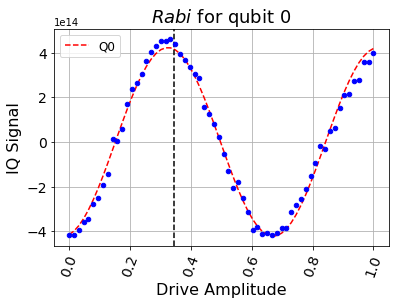

In [22]:
rabi_backend_fit = RabiFitter(rabi_result, xdata, qubits, fit_p0 = [2.0e15, 2, 0, 0])

# get the pi amplitude
pi_amp = rabi_backend_fit.pi_amplitude(0)

# plot
rabi_backend_fit.plot(0)
print('Pi Amp: %f'%pi_amp)

# 3. Reproducing the Rabi oscillations with the simulator <a name='simulator'></a>

Next, we run the same experiments on the pulse simulator. This section demonstrates the use of the `PulseSystemModel.from_backend` function for generating `PulseSystemModel` objects from a backend. 

**Note:** Currently not all system Hamiltonian information is available to the public, missing values have been replaced with $0$. As a result, in this notebook, we need to insert parameters into the backend object by hand. Specifically, we:
- Set the frequency of the qubit in the backend provided Hamiltonian to correspond with the backend provided estimate.
- Set the value of the drive strength to be consistent with the $\pi$-pulse amplitude found in the previous section. I.e. The drive strength $r$ is set so that: $r \times A = \pi/2$, where $A$ is the area under the $\pi$-pulse found above.

In [23]:
# A value to use if previous cells of notebook were not run
# pi_amp = 0.347467

# Infer the value of the drive strength from the pi pulse amplitude:
dt = getattr(armonk_backend.configuration(), 'dt')
from qiskit.pulse import pulse_lib
sample_array = pulse_lib.gaussian(duration=drive_duration, amp=1, sigma=drive_sigma).samples
A = pi_amp*sum(sample_array*dt) # area under curve
omegad0 = np.real(np.pi/(A * 2)) # inferred drive strength

# set drive strength omegad0 in backend object
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = omegad0
# set the qubit frequency from the estimate in the defaults
freq_est = getattr(armonk_backend.defaults(), 'qubit_freq_est')[0]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

In [35]:
omegad0

31919806.545849085

Construct a `PulseSystemModel` object from the backend, and instantiate the simulator.

In [32]:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

backend_sim = PulseSimulator(configuration=armonk_backend.configuration())

Assemble schedules as before, but now use `PulseSimulator` as the backend.

In [33]:
rabi_qobj_sim = assemble(rabi_schedules, 
                         backend=backend_sim,
                         meas_level=1, 
                         meas_return='avg', 
                         shots=512)

Run the simulation and get the results.

In [34]:
sim_result = backend_sim.run(rabi_qobj_sim, armonk_model).result()

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

Generate the same plot.

In [ ]:
rabi_sim_fit = RabiFitter(sim_result, xdata, qubits, fit_p0 = [1.5, 2, 0, 0])
rabi_sim_fit.plot(0)

Observe: the simulated results reproduce the oscillations of the device (the amplitude of the oscillation is arbitrary).

In [28]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright